# Práctica 6 - Modularidad e Identificación de Comunidades

## Objetivo
En esta práctica se propone implementar en una función para el cálculo de la modularidad de una red, y posteriormente implementar el algoritmo de Girvan-Newman para la partición de una red mediante la eliminación sucesiva de los enlaces de mayor betweenness.
## 1 Modularidad
### 1.1 Implementar una función que calcula la modularidad de una red no dirigida para una partición de los nodos propuesta. 
La función tendrá como argumentos de entrada:
- Un objeto Graph (Networkx)
- Un diccionario con la partición, e.g. { ‘node1’: c1, ‘node2’:c2, …}



In [4]:
#Imports
import networkx as nx
from itertools import product
from networkx.algorithms import community

import numpy as np
import matplotlib.pyplot as plt

Función que calcula la modularidad de una red ND para una particion de nodos.

In [5]:
def calcularModularidad(red, diccionario):
    Q = 0

    nx.set_edge_attributes(red, {e:1 for e in red.edges}, 'peso')

    A = nx.to_scipy_sparse_matrix(red).astype(float)

    out_degree = in_degree = dict(nx.degree(red))
    m = red.number_of_edges()
    nodos = list(red)

    for i, j in product(range(len(nodos)),range(len(nodos))):
        if(diccionario[nodos[i]] == diccionario[nodos[j]]):
            Q += np.sum(A[i,j] - (out_degree[nodos[i]]*in_degree[nodos[j]]/(2*m)))
    
    return Q/(2*m)



### 1.2 Comprobar el valor de la modularidad para los siguientes ejemplos:
##### 1 Ejemplo de Wikipedia 
Modularidad de la partición de colores = 0.4896


In [6]:
def definicionGrafo():
    # Creamos el grafo de la red de contactos propuesta
    G = nx.Graph()
    # Agregamos los nodos
    G.add_edges_from([(1,2),(1,3),(3,2),(1,4),(4,5),(5,6),(6,7),(7,5),(4,8),(8,9),(9,10),(10,8)])


    # Creamos el diccionario de nodos
    nodos = list(G)
    diccionario = {}
    for e in nodos:
        if e <= 4:
            diccionario[e] = 1
        elif 5 <= e <= 8:
            diccionario[e] = 2
        else:
            diccionario[e] = 3

    return G, diccionario

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2408\3533271965.py:6: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  A = nx.to_scipy_sparse_matrix(red).astype(float)


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

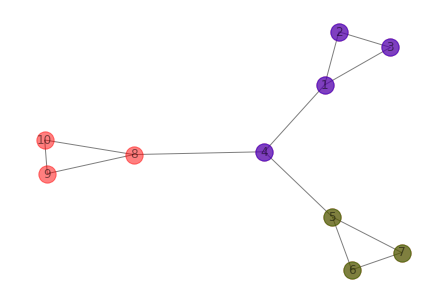

In [7]:
red, nodos = definicionGrafo()

pos = nx.fruchterman_reingold_layout(red,k=0.25)
nx.draw(red, pos, with_labels=True, node_color='r', alpha=0.5)
nx.draw_networkx_nodes(red, pos, nodelist=[1,2,3,4], node_color='b', alpha=0.5)
nx.draw_networkx_nodes(red, pos, nodelist=[5,6,7], node_color='g', alpha=0.5)

print("La modularidad de la red es:", calcularModularidad(red, nodos))

##### 2 Ejemplo de clase #####

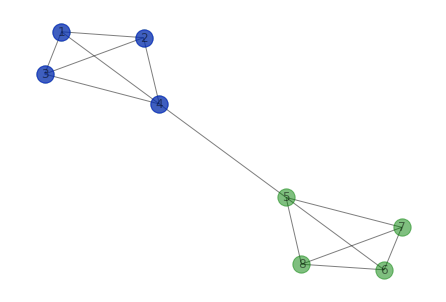

In [ ]:
def definicionGrafo2():
    G = nx.Graph()
    G.add_edges_from([(1,2),(1,3),(1,4),(2,3),(2,4),(3,4),(4,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8)])
    pos = nx.fruchterman_reingold_layout(G,k=0.25)
    nx.draw(G, pos, with_labels=True, node_color='g', alpha=0.5)
    nx.draw_networkx_nodes(G, pos, nodelist=[1,2,3,4], node_color='b', alpha=0.5)

    return G

red2 = definicionGrafo2()

1. Para una partición correspondiente a toda la red (modularidad = 0)

In [ ]:
nodos = list(red2)
diccionario = {}
for e in nodos:
    diccionario[e] = 1

print("La modularidad es:", calcularModularidad(red2, diccionario))

2. Para una partición correspondiente a cada nodo (modularidad = -0.1272)

In [ ]:
diccionario2 = {}
num = 1
for e in nodos:
    diccionario2[e] = num
    num += 1   

print("La modularidad es:", calcularModularidad(red2, diccionario2))

3. Para la partición de colores (modularidad = 0.4231)

In [ ]:
diccionario3 = {}
for e in nodos:
    if e <= 4:
        diccionario3[e] = 1
    else:
        diccionario3[e] = 2

print("La modularidad es:", calcularModularidad(red2, diccionario3))

## 2 Detección de comunidades basada en la eliminación de enlaces
### 2.1 Implementar la detección de comunidades basada en la eliminación recursiva de enlaces “shortest-path betweenness” propuesta por Newman y Girvan

In [ ]:
# Eliminamos los bordes
# Calculamos el edge betweenness
def eliminarBordes(G):
    conectados = nx.number_connected_components(G)
    ncomponentes = conectados
    while ncomponentes <= conectados:
        centralidadIn = nx.edge_betweenness_centrality(G,weight='peso')

        # Buscamos el borde con mayor centralidad
        maximo = max(centralidadIn.values())

        for j,i in centralidadIn.values():
            if float(i) == maximo:
                G.remove_edge(j[0],j[1])
        
        ncomponentes = nx.number_connected_components(G)

In [ ]:
# Calculamos la modularidad de la partición
def calcularModularidadGirvanNewman(G,diccionario,peso):
    nuevaMatrix = nx.adj_matrix(G)
    diccAuxiliar = {}
    diccAuxiliar = actualizarDicc(nuevaMatrix, G.nodes())

    # Calculamos la modularidad
    Q = 0
    comp = nx.connected_components(G) # Lista de componentes
    for e in comp:
        bordesSinComunidad = 0
        bordesAl = 0
        for i in e: 
            bordesSinComunidad += diccAuxiliar[i]
            bordesAl += diccionario[i]
        Q += (float(bordesSinComunidad) - float(bordesAl*bordesAl)/float(2*peso))
    Q = Q/float(2*peso)
    return Q

In [ ]:
# Actualizamos el diccionario
def actualizarDicc(A,nodos):
    dicc = {}
    B = A.sum(axis=1)  
    i = 0
    for nodo in list(nodos):
        dicc[nodo] = B[i,0]
        i += 1
    return dicc

In [ ]:
# Ejecutamos el algoritmo
def ejecutarGirvanNewman(G, diccionario, peso):
    diccModularidad = {}
    mejorParticion = 0
    maxModularidad = 0

    # Variable para encontrar la mejor partición
    maxModularidad = 0.0
    Q = 0.0
    while True:
        eliminarBordes(G)
        Q = calcularModularidadGirvanNewman(G,diccionario,peso)
        if G.number_of_edges() == 0:
            break

    for key, value in diccModularidad.items():
        if value > maxModularidad:
            maxModularidad = value
            mejorParticion = key
    
    return diccModularidad, mejorParticion
       

Mostrar un gráfico con la modularidad vs el número de particiones

In [ ]:
particiones = []
modularidad = []

for key, value in diccModularidad.items():
    particiones.append(key)
    modularidad.append(value)

fig, ax = plt.subplots()
ax.set_xlabel('Particiones')
ax.set_ylabel('Modularidad')
ax.plot(particiones, modularidad)
ax.grid(axis = 'x', color = 'gray')
plt.show()

NameError: name 'diccModularidad' is not defined

### 2.2 Comprobar el algoritmo de detección de comunidades anterior con la red “Zachary’s karate club” que se encuentra dentro de la librería de Networkx.


In [ ]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
A = nx.adj_matrix(G)

# Peso de los bordes
peso = 0.0
for i in range(0, n):
    for j in range(0, n):
        peso += A[i,j]
peso = peso/2.0

# Grafo de cada nodo
diccionario = actualizarDicc(A, G.nodes())

# Ejecutamos el algoritmo
diccModularidad, mejorParticion = ejecutarGirvanNewman(G, diccionario, peso)

print("La particion con maximo valor de modularidad es:", mejorParticion, " y una modularidad de: ", diccModularidad[mejorParticion])

Mostrar un gráfico con la modularidad vs el número de divisiones

In [ ]:
divisiones = []
modularidad = []

for key, value in diccModularidad.items():
    divisiones.append(key)
    modularidad.append(value)

fig, ax = plt.subplots()
ax.set_xlabel('Divisiones')
ax.set_ylabel('Modularidad')
ax.plot(divisiones, modularidad)
ax.grid(axis = 'x', color = 'gray')
plt.show()